In [1]:
"""
NVIDIA DALI examples
@author: Bari Arviv
"""
import os.path 
import fnmatch 
import numpy as np
import nvidia.dali.ops as ops     
import matplotlib.pyplot as plt
import nvidia.dali.types as types 
import matplotlib.gridspec as gridspec
from nvidia.dali.pipeline import Pipeline
from timeit import default_timer as timer

In [2]:
## Clases:

In [3]:
class HybridPipeline(Pipeline):
    """The HybridPipeline class is a subclass of dali.pipeline.Pipeline, which provides most 
       of the methods to create and launch a pipeline. The pipeline splits the decoding 
       process between CPU and GPU, significantly reducing the decoding time.
    """
    def __init__(self, image_dir, batch_size, num_threads, device_id, initial_fill):
        super(HybridPipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = image_dir, random_shuffle = True, initial_fill = initial_fill)
        # ImageDecoder with device=mixed uses a hybrid approach of computation that employs both the CPU
        # and the GPU. This means that it accepts CPU inputs, but returns GPU outputs. That is why images
        # objects returned from the pipeline are of type TensorListGPU.
        self.decode = ops.ImageDecoder(device = "mixed", output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        # images are on the GPU
        return (images, labels)

In [4]:
class RandomRotatedSimplePipeline(Pipeline):
    """The RandomRotatedSimplePipeline class is a subclass of dali.pipeline.Pipeline, which provides 
       most of the methods to create and launch a pipeline. The addition to this class is an operator 
       that rotates the images by a random angle in a given range.
    """
    def __init__(self, image_dir, batch_size, num_threads, device_id, initial_fill):
        super(RandomRotatedSimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = image_dir, random_shuffle = True, initial_fill = initial_fill)
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)
        self.rotate = ops.Rotate()
        # uses dali.ops.Uniform to make a pipeline with random rotation
        self.rng = ops.Uniform(range = (-10.0, 10.0))

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        angle = self.rng()
        rotated_images = self.rotate(images, angle = angle)
        return (rotated_images, labels)

In [5]:
class SimplePipeline(Pipeline):
    """The SimplePipeline class is a subclass of dali.pipeline.Pipeline,  
       which provides most of the methods to create and launch a pipeline.
    """
    def __init__(self, image_dir, batch_size, num_threads, device_id, initial_fill = 0, random_shuffle = False):
        # first, call superclass constructor, in order to set the global parameters of the pipeline.
        super(SimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        # traverses the directory and returns pairs of (encoded image, label)
        if not random_shuffle:
            self.input = ops.FileReader(file_root = image_dir)
        else:
            self.input = ops.FileReader(file_root = image_dir, random_shuffle = random_shuffle,
                                        initial_fill = initial_fill)   
        # takes an encoded image input and outputs decoded RGB image
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)

    def define_graph(self):
        """The function define the actual flow of computation.
           :return: pairs of (images, labels)
           :rtype:  tuple
        """
        # uses input operation to create jpegs (encoded images) and labels
        jpegs, labels = self.input() 
        # next, uses the decode operation to create images (decoded RGB images).
        images = self.decode(jpegs)
        return (images, labels)

In [6]:
## Methods:

In [7]:
def preparation_dict(image_dir):
    """The function prepares a directory structure containing pictures from the defined path.
       :param image_dir: path to the images folder.
       :type image_dir:  string
    """
    for root, dir, files in os.walk(image_dir):
        depth = root.count('/')
        ret = ""
        
        if depth > 0:
            ret += "  " * (depth - 1) + "|-"    
        print(ret + root)
        
        for items in fnmatch.filter(files, "*"):
            print(" " * len(ret) + "|-" + items)

In [8]:
def tensor_to_numpy(tensor):
    """The function sends the data from DALI’s Tensor to NumPy array. The function uses the 
       is_dense_tensor function to check if the data can be sent and returns an answer accordingly.
       :param tensor: DALI’s Tensor
       :type tensor:  TensorList
       :return: answer if is possible to send the data.
       :rtype:  boolean
    """
    if not tensor.is_dense_tensor():
        return False
        
    obj_tensor = tensor.as_tensor()
    print(obj_tensor.shape())
    print(np.array(obj_tensor))
    return True

In [9]:
def show_images(image_batch, batch_size, columns):
    """The function prints the images in the image_batch received."""
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

In [10]:
def speedtest(pipeclass, image_dir, batch, n_threads, device_id, count_image):
    """The function calculates the speed of the pipeline class received with n_threads CPU threads."""
    pipe = pipeclass(image_dir, batch, n_threads, device_id, count_image)
    pipe.build()
    
    # warmup
    for i in range(5):
        pipe.run()
    
    # test
    n_test = 20
    t_start = timer()
    for i in range(n_test):
        pipe.run()
    
    t = timer() - t_start
    print("Speed: {} imgs/s".format((n_test * batch)/t))

In [11]:
## Main Program:

In [12]:
columns = 4
device_id = 0
batch_size = 8
num_threads = 1
count_image = 21
image_dir = "data/images"

# preparation of a directory structure containing pictures of dogs and cats
preparation_dict(image_dir)

|-data/images
  |-data/images/.ipynb_checkpoints
  |-data/images/cat
    |-cat_7.jpg
    |-cat_8.jpg
    |-cat_11.jpg
    |-cat_3.jpg
    |-cat_9.jpg
    |-cat_10.jpg
    |-cat_2.jpg
    |-cat_5.jpg
    |-cat_4.jpg
    |-cat_6.jpg
    |-cat_1.jpg
    |-data/images/cat/.ipynb_checkpoints
      |-cat_1-checkpoint.jpg
      |-cat_2-checkpoint.jpg
  |-data/images/dog
    |-dog_8.jpg
    |-dog_3.jpg
    |-dog_9.jpg
    |-dog_6.jpg
    |-dog_1.jpg
    |-dog_2.jpg
    |-dog_5.jpg
    |-dog_10.jpg
    |-dog_7.jpg
    |-dog_4.jpg
    |-data/images/dog/.ipynb_checkpoints
      |-dog_3-checkpoint.jpg
      |-dog_1-checkpoint.jpg
      |-dog_7-checkpoint.jpg
      |-dog_4-checkpoint.jpg
      |-dog_8-checkpoint.jpg
      |-dog_9-checkpoint.jpg
      |-dog_10-checkpoint.jpg
      |-dog_5-checkpoint.jpg
      |-dog_2-checkpoint.jpg
      |-dog_6-checkpoint.jpg


In [13]:
# building the pipeline
pipe = SimplePipeline(image_dir, batch_size, num_threads, device_id)
pipe.build()

# running the pipeline: After the pipeline is built, run it to get the batch of results.
pipe_out = pipe.run()
print(pipe_out)

(<nvidia.dali.backend_impl.TensorListCPU object at 0x7f6645334880>, <nvidia.dali.backend_impl.TensorListCPU object at 0x7f6645334928>)


In [14]:
# in order to show the results (just for debugging purposes - during the actual training we would
# not do that step, as it would make our batch of images do a round trip from GPU to CPU and back)
# we can send our data from DALI’s Tensor to NumPy array.
images, labels = pipe_out
print("Images is_dense_tensor: " + str(tensor_to_numpy(images)))

Images is_dense_tensor: False


In [15]:
print("Labels is_dense_tensor: " + str(tensor_to_numpy(labels)))

[8, 1]
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Labels is_dense_tensor: True


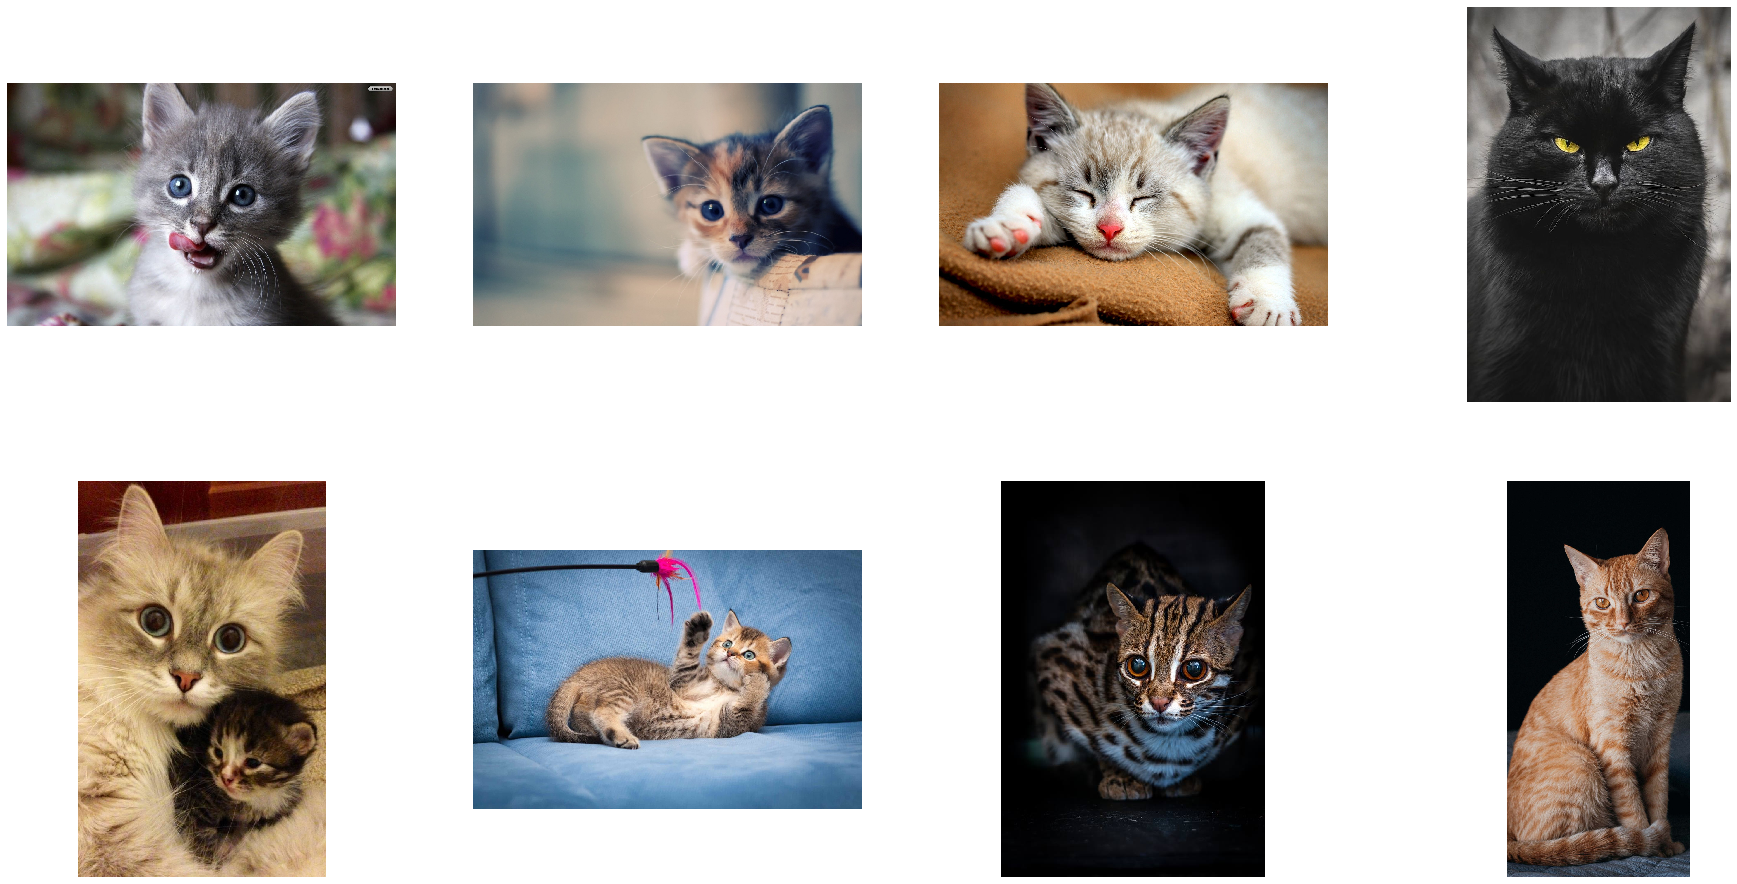

In [16]:
# in order to see the images, we will need to loop over all tensors 
# contained in TensorList, accessed with its at method.
show_images(images, batch_size, columns)

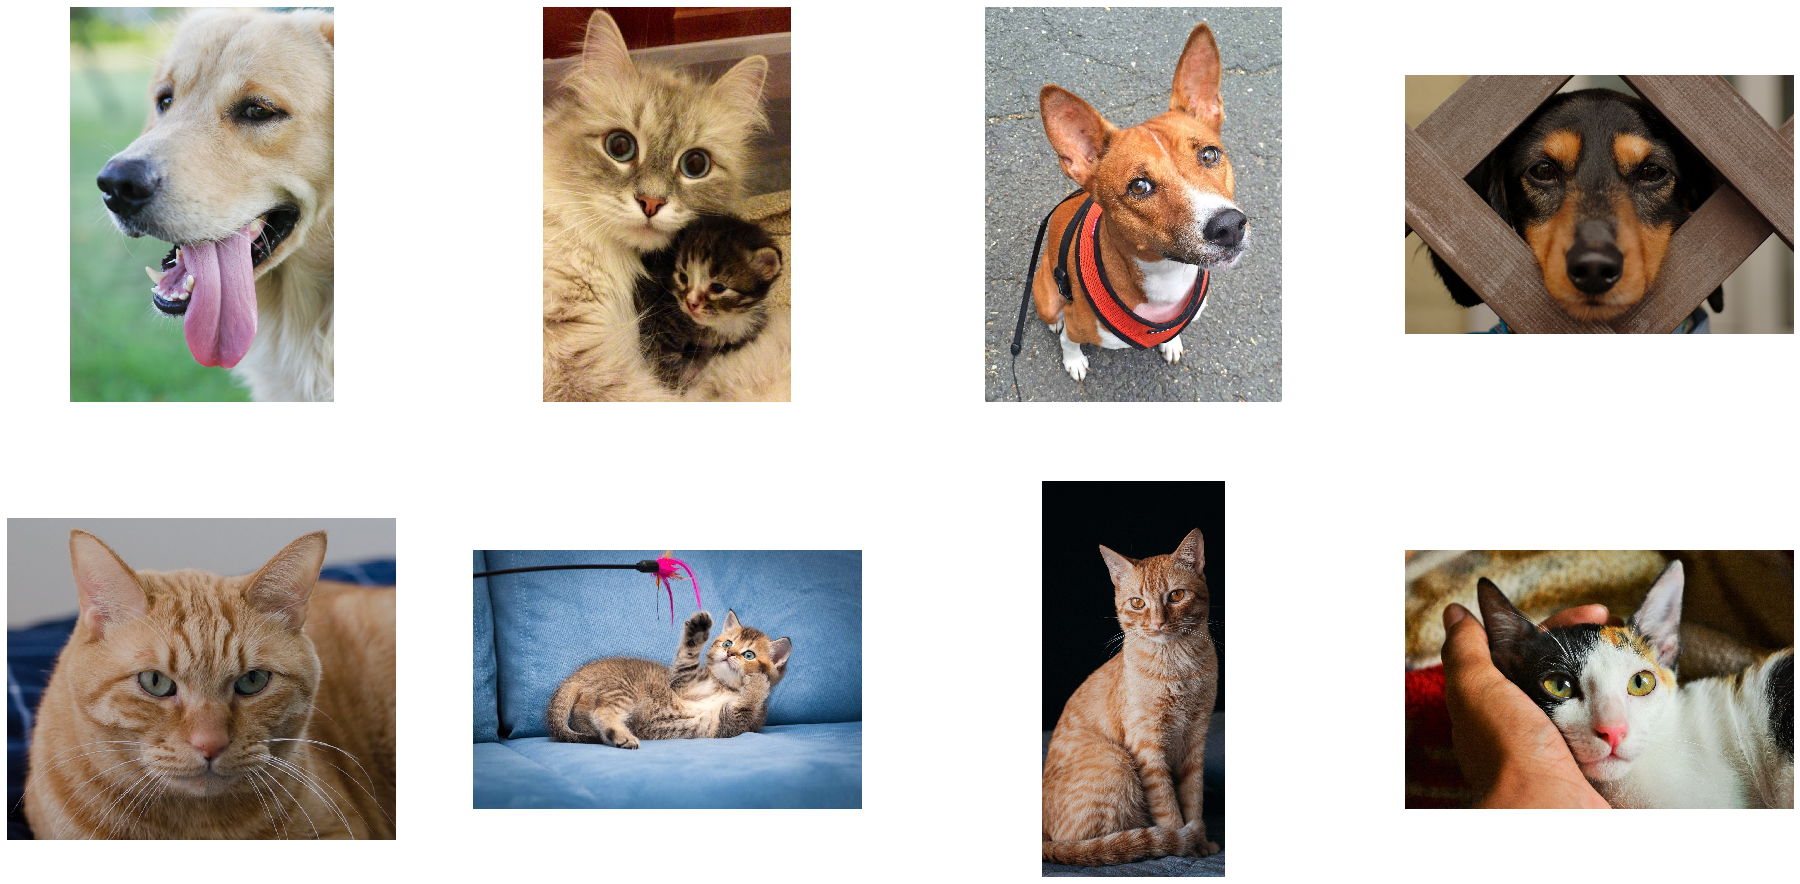

In [17]:
## Adding augmentations
# Random shuffle: building a new pipeline
pipe2 = SimplePipeline(image_dir, batch_size, num_threads, device_id, count_image, True)
pipe2.build()
pipe_out2 = pipe2.run()
images2, labels2 = pipe_out2
show_images(images2, batch_size, columns)

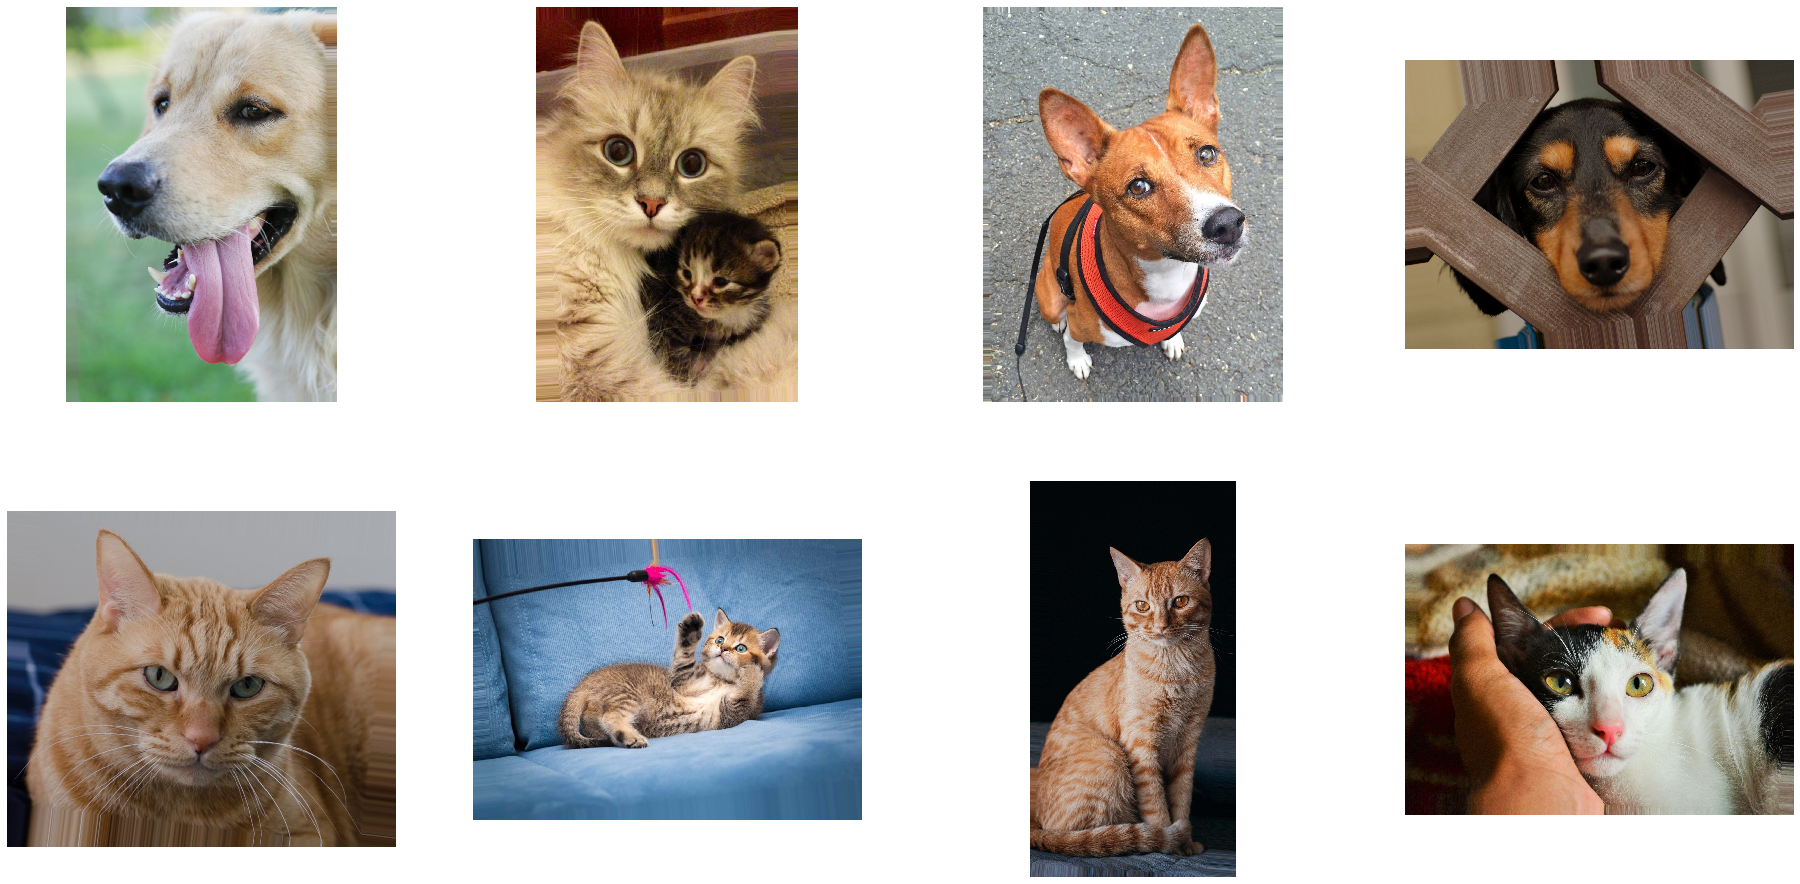

In [18]:
## Augmentations - Tensors as arguments and Random Number Generation
# DALI can not only read images from disk and batch them into tensors, it can also perform various
# augmentations on those images to improve Deep Learning training results. One example of such 
# augmentations is rotation. Build a new pipeline, which rotates the images before outputting them.
pipe3 = RandomRotatedSimplePipeline(image_dir, batch_size, num_threads, device_id, count_image)
pipe3.build()
pipe_out3 = pipe3.run()
images3, labels3 = pipe_out3
show_images(images3, batch_size, columns)

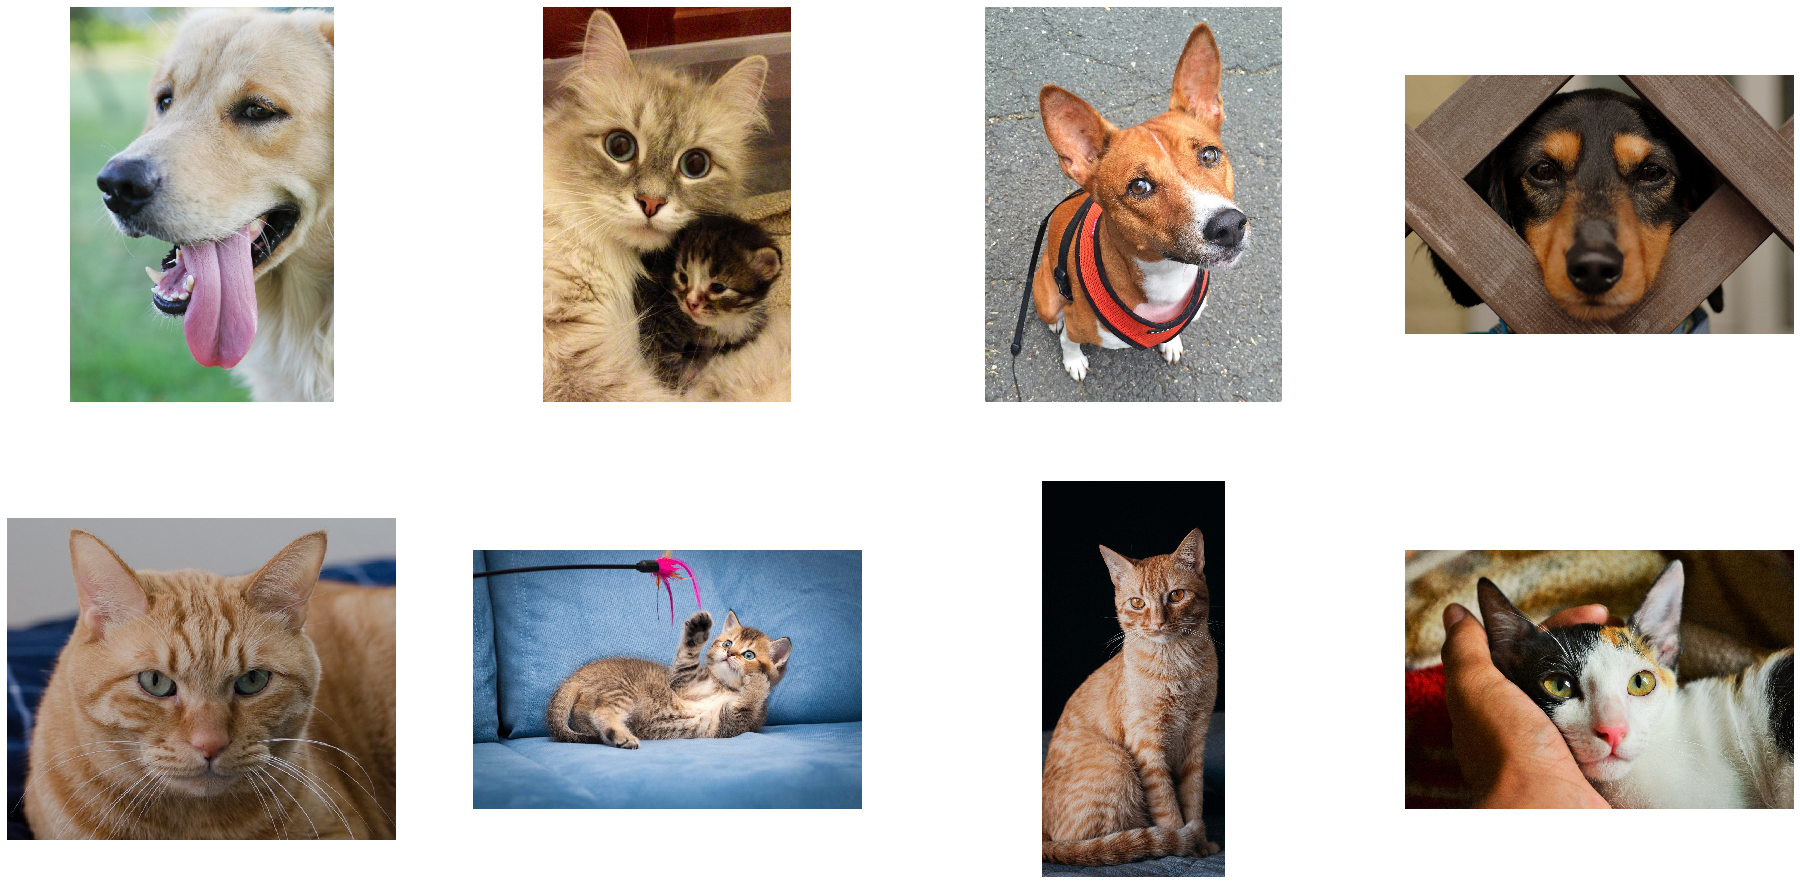

In [19]:
## Hybrid decoding
# sometimes, especially for higher resolution images, decoding images stored in JPEG format may
# become a bottleneck. To address this problem, nvJPEG library was developed. It splits the 
# decoding process between CPU and GPU, significantly reducing the decoding time.
pipe4 = HybridPipeline(image_dir, batch_size, num_threads, device_id, count_image)
pipe4.build()
pipe_out4 = pipe4.run()
images4, labels4 = pipe_out4
    
# we cannot access contents of TensorListGPU directly from the CPU, so in order 
# to visualize the result we need to copy it to the CPU by using as_cpu method.
show_images(images4.as_cpu(), batch_size, columns)

In [20]:
# Let us compare the speed of ImageDecoder for ‘cpu’ and ‘mixed’ backends by measuring
# speed of RandomRotatedSimplePipeline and HybridPipeline with 4 CPU threads.
num_threads_test = 4
test_batch_size = 64
speedtest(RandomRotatedSimplePipeline, image_dir, test_batch_size, num_threads_test, device_id, count_image)

Speed: 7.116925053156627 imgs/s


In [21]:
speedtest(HybridPipeline, image_dir, test_batch_size, num_threads_test, device_id, count_image)

Speed: 204.52131457731554 imgs/s
